Zaimplementuj własny model rozmyty. Możesz korzystać z bibliotek (numpy itp.) z wyłączeniem bibliotek implementujących systemy rozmyte.

Model powinien pozwalać na:

Zdefiniowanie zmiennych wejściowych wraz z ich zakresem.
Zdefiniowanie na zmiennych wejściowych zbiorów rozmytych wraz z ich nazwą i kształtem funkcji przynależności (trójkątna i trapezoidalna)
Zdefiniowanie reguł opierających się na zmiennych wejściowych i zbiorach na nich opisanych. Wyjście reguły jest wartością liczbową zmiennej wyjściowej (Model TSK 0-rzędu)
Określenie stopnia prawdziwości poprzednika reguły
Określenie wartości zmiennej wyjściowej w oparciu o model wnioskowania TSK
Wykorzystaj zaimplementowany model do określenia wartości napiwku (procentowo, 0-15) na postawie jakości jedzenia (0-10) i jakości obsługi (0-10).

In [170]:
import numpy as np
import copy
from matplotlib import pyplot as plt

In [171]:
class Rule():
    def __init__(self, input_1=list, operator=str, input_2=list, output=list):
        self.input_1 = input_1
        self.input_2 = input_2
        self.operator = operator
        self.output = output


class Input():
    def __init__(self, input_range: np.ndarray, name: str):
        self.input_range = input_range
        self.name = name
        self.poor = []
        self.average = []
        self.good = []
        self.values = {'poor': self.poor, 'average': self.average, 'good': self.good}

    def auto_tri(self):
        x = self.input_range[-1]
        self.poor = [0, 0, x / 2]
        self.average = [0, x / 2, x]
        self.good = [x / 2, x, x]
        self.values = {'poor': self.poor, 'average': self.average, 'good': self.good}

    def auto_tra(self):
        x = self.input_range[-1]
        bias = x / 5
        self.poor = [0, 0, bias, x / 2 - bias / 2]
        self.average = [bias, x / 2 - bias / 2, x / 2 + bias / 2, x - bias]
        self.good = [x / 2 + bias / 2, x - bias, x, x]
        self.values = {'poor': self.poor, 'average': self.average, 'good': self.good}


class Output():
    def __init__(self, input_range: np.ndarray, name: str):
        self.input_range = input_range
        self.name = name
        self.poor = []
        self.average = []
        self.good = []
        self.values = {'poor': self.poor, 'average': self.average, 'good': self.good}

    def auto_tri(self):
        x = self.input_range[-1]
        self.poor = [0, 0, x / 2]
        self.average = [0, x / 2, x]
        self.good = [x / 2, x, x]
        self.values = {'poor': self.poor, 'average': self.average, 'good': self.good}

    def auto_tra(self):
        x = self.input_range[-1]
        bias = x / 5
        self.poor = [0, 0, bias, x / 2 - bias / 2]
        self.average = [bias, x / 2 - bias / 2, x / 2 + bias / 2, x - bias]
        self.good = [x / 2 + bias / 2, x - bias, x, x]
        self.values = {'poor': self.poor, 'average': self.average, 'good': self.good}


class FuzzyModel():
    def __init__(self, inputs_values: dict, inputs_dict: dict, rules: list, output: Output):
        self.rules = rules
        self.inputs_dict = inputs_dict
        self.output = output
        self.inputs_values = inputs_values
        self.inputs_membered = dict()
        self.y_array = None
        self.template_array = None

    def singular_membership(self, value: float, ranges: list) -> float:
        if len(ranges) == 3:
            a, b, c = ranges

            if value <= b:
                max_value = b - value
                min_value = value - a
                sum_values = min_value + max_value
                if sum_values == 0:
                    return 1
                membership = round(min_value / sum_values, 5)
                if membership < 0: return 0
                return membership

            max_value = c - value
            min_value = value - b
            sum_values = min_value + max_value
            if sum_values == 0:
                return 1
            membership = round(max_value / sum_values, 5)
            if membership < 0: return 0
            return membership

        elif len(ranges) == 4:
            a, b, c, d = ranges

            if b < value <= c:
                return 1

            elif c < value <= d:
                max_value = d - value
                min_value = value - c
                sum_values = min_value + max_value
                if sum_values == 0:
                    return 1
                membership = round(max_value / sum_values, 5)
                return membership

            elif a < value <= b:
                max_value = b - value
                min_value = value - a
                sum_values = min_value + max_value
                if sum_values == 0:
                    return 1
                membership = round(min_value / sum_values, 5)
                return membership

            return 0

    def membership_function(self):
        for input in list(self.inputs_values.keys()):
            inputs_membered_dict = dict()
            for fuzzy_variable in self.inputs_dict[input].values.items():
                inputs_membered_dict[fuzzy_variable[0]] = (
                    self.singular_membership(self.inputs_values[input], fuzzy_variable[1]))

            self.inputs_membered[input] = inputs_membered_dict

    def deposit_rule_on_output(self, global_y_array: np.array, rule: Rule):

        index_output = list(self.output.values.keys()).index(rule.output[1])

        match rule.operator:
            case 'AND':
                cut = min(self.inputs_membered[rule.input_1[0]][rule.input_1[1]],
                          self.inputs_membered[rule.input_2[0]][rule.input_2[1]])
            case 'OR':
                cut = max(self.inputs_membered[rule.input_1[0]][rule.input_1[1]],
                          self.inputs_membered[rule.input_2[0]][rule.input_2[1]])

        cut_y_array = np.where(self.template_array[index_output] > cut, cut, self.template_array[index_output])
        return np.where(global_y_array >= cut_y_array, global_y_array, cut_y_array)

    def create_template_outcome_arrays(self):
        x_array = copy.deepcopy(self.output.input_range)
        number_of_categories = len(self.output.values.keys())
        self.template_array = np.zeros((number_of_categories, len(x_array)))

        for category in range(number_of_categories):
            for sample in range(len(x_array)):
                self.template_array[category, sample] = self.singular_membership(x_array[sample],
                                                                                 list(self.output.values.values())[category])

    def calculate(self):
        global_y_array = np.zeros(self.output.input_range.shape[0])

        for rule in self.rules:
            global_y_array = self.deposit_rule_on_output(global_y_array, rule)

        self.y_array = global_y_array

    def output_value(self):
        value = 0
        value += sum([self.output.input_range[x] * self.y_array[x] for x in range(len(self.output.input_range))])

        return round(value / sum(self.y_array), 2)

In [172]:
quality = Input(np.arange(0, 10.1, 0.1), 'quality')
service = Input(np.arange(0, 10.1, 0.1), 'service')
tip = Output(np.arange(0, 15.1, 0.1), 'tip')

inputs_dict = {quality.name: quality,
               service.name: service,
               }

In [173]:
quality.auto_tra()
service.auto_tra()
tip.auto_tra()

In [174]:
inputs_values = {'quality': 4.87,
                 'service': 7.41}

rules = [Rule(['quality', 'poor'], 'AND', ['service', 'poor'], ['tip', 'poor']),
         Rule(['quality', 'poor'], 'AND', ['service', 'average'], ['tip', 'poor']),
         Rule(['quality', 'average'], 'AND', ['service', 'poor'], ['tip', 'poor']),
         Rule(['quality', 'poor'], 'AND', ['service', 'good'], ['tip', 'average']),
         Rule(['quality', 'good'], 'AND', ['service', 'poor'], ['tip', 'average']),
         Rule(['quality', 'average'], 'AND', ['service', 'average'], ['tip', 'average']),
         Rule(['quality', 'good'], 'AND', ['service', 'average'], ['tip', 'good']),
         Rule(['quality', 'average'], 'AND', ['service', 'good'], ['tip', 'good']),
         Rule(['quality', 'good'], 'AND', ['service', 'good'], ['tip', 'good']),
         ]

In [175]:
model = FuzzyModel(inputs_values=inputs_values, inputs_dict=inputs_dict, rules=[], output=tip)
model.membership_function()
model.inputs_membered

{'quality': {'poor': 0, 'average': 1, 'good': 0},
 'service': {'poor': 0, 'average': 0.295, 'good': 0.705}}

In [176]:
model.create_template_outcome_arrays()

In [177]:
model.calculate()

In [178]:
print(f'Tip should be {model.output_value()}')

Tip should be 10.48


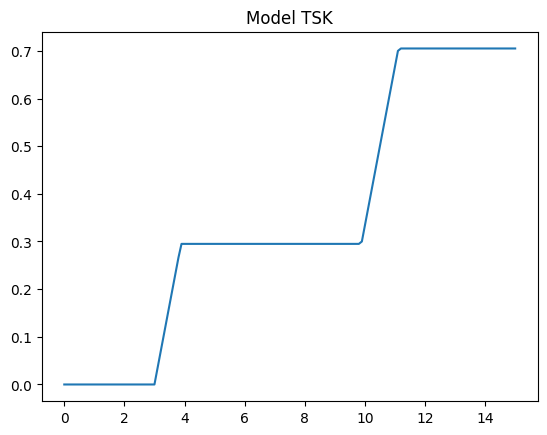

In [182]:
plt.title('Model TSK')
plt.plot(model.output.input_range, model.y_array)
plt.show()

In [180]:
model.inputs_membered

{'quality': {'poor': 0, 'average': 1, 'good': 0},
 'service': {'poor': 0, 'average': 0.295, 'good': 0.705}}